In [ ]:
import torch
from torch import nn
from torch import functional as F
from torch import optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU: ', torch.cuda.get_device_name(0))

else:
    device = torch.device("cpu")
    print('No GPU available')

class Attention(nn.Module):
       
    def __init__(self, embed_dim, heads=8, activation=None, dropout=0.1):
        super(Attention, self).__init__()
        self.heads = heads
        self.embed_dim = embed_dim
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.softmax = nn.Softmax(dim=-1)
        if activation == 'relu':
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        query = self.activation(self.query(inp))
        key   = self.activation(self.key(inp))
        value = self.activation(self.value(inp))

        # output of _reshape_heads(): (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        query = self._reshape_heads(query)
        key   = self._reshape_heads(key)
        value = self._reshape_heads(value)

        # attention_scores: (batch_size * heads, seq_len, seq_len) | Softmaxed along the last dimension
        attention_scores = self.softmax(torch.matmul(query, key.transpose(1, 2)))

        # out: (batch_size * heads, seq_len, reduced_dim)
        out = torch.matmul(self.dropout(attention_scores), value)
        
        # output of _reshape_heads_back(): (batch_size, seq_len, embed_size)
        out = self._reshape_heads_back(out)

        return out, attention_scores

    def _reshape_heads(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()

        reduced_dim = self.embed_dim // self.heads
        assert reduced_dim * self.heads == self.embed_dim
        out = inp.reshape(batch_size, seq_len, self.heads, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(-1, seq_len, reduced_dim)

        # out: (batch_size * heads, seq_len, reduced_dim)
        return out

    def _reshape_heads_back(self, inp):
        # inp: (batch_size * heads, seq_len, reduced_dim) | reduced_dim = embed_dim // heads
        batch_size_mul_heads, seq_len, reduced_dim = inp.size()
        batch_size = batch_size_mul_heads // self.heads

        out = inp.reshape(batch_size, self.heads, seq_len, reduced_dim)
        out = out.permute(0, 2, 1, 3)
        out = out.reshape(batch_size, seq_len, self.embed_dim)

        # out: (batch_size, seq_len, embed_dim)
        return out

class FeedForward(nn.Module):

    def __init__(self, embed_dim, forward_expansion=1, dropout=0.1):
        super(FeedForward, self).__init__()
        self.embed_dim = embed_dim
        self.fc1 = nn.Linear(embed_dim, embed_dim * forward_expansion)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim * forward_expansion, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.dropout(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, seq_len, embed_dim)
        return out 

class TransformerBlock(nn.Module):

    def __init__(self, embed_dim, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.embed_dim = embed_dim
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attention = Attention(embed_dim, heads, activation, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = FeedForward(embed_dim, forward_expansion, dropout)

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)
        batch_size, seq_len, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        res = inp
        out = self.norm1(inp)
        out, _ = self.attention(out)
        out = out + res
        
        res = out
        out = self.norm2(out)
        out = self.feed_forward(out)
        out = out + res

        # out: (batch_size, seq_len, embed_dim)
        return out

class Transformer(nn.Module):

    def __init__(self, embed_dim, layers, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(Transformer, self).__init__()
        self.embed_dim = embed_dim
        self.trans_blocks = nn.ModuleList(
            [TransformerBlock(embed_dim, heads, activation, forward_expansion, dropout) for i in range(layers)]
        )

    def forward(self, inp):
        # inp: (batch_size, seq_len, embed_dim)

        out = inp
        for block in self.trans_blocks:
            out = block(out)

        # out: (batch_size, seq_len, embed_dim)
        return out

class ClassificationHead(nn.Module):

    def __init__(self, embed_dim, classes, dropout=0.1):
        super(ClassificationHead, self).__init__()
        self.embed_dim = embed_dim
        self.classes = classes
        self.fc1 = nn.Linear(embed_dim, embed_dim // 2)
        self.activation = nn.GELU()
        self.fc2 = nn.Linear(embed_dim // 2, classes)
        self.softmax = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, inp):
        # inp: (batch_size, embed_dim)
        batch_size, embed_dim = inp.size()
        assert embed_dim == self.embed_dim

        out = self.dropout(self.activation(self.fc1(inp)))
        # out = self.softmax(self.fc2(out))
        out = self.fc2(out)

        # out: (batch_size, classes) 
        return out

class VisionTransformer(nn.Module):

    def __init__(self, patch_size, max_len, embed_dim, classes, layers, channels=3, heads=8, activation=None, forward_expansion=1, dropout=0.1):
        super(VisionTransformer, self).__init__()
        self.name = 'VisionTransformer'
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.channels = channels
        self.patch_to_embed = nn.Linear(patch_size * patch_size * channels, embed_dim)
        self.position_embed = nn.Parameter(torch.randn((max_len, embed_dim)))
        self.transformer = Transformer(embed_dim, layers, heads, activation, forward_expansion, dropout)
        self.classification_head = ClassificationHead(embed_dim, classes)
        self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim))

    def forward(self, inp):
        # inp: (batch_size, channels, width, height)
        batch_size, channels, width, height = inp.size()
        assert channels == self.channels

        out = inp.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size).contiguous()
        out = out.view(batch_size, channels, -1, self.patch_size, self.patch_size)
        out = out.permute(0, 2, 3, 4, 1)
        # out: (batch_size, seq_len, patch_size, patch_size, channels) | seq_len would be (width*height)/(patch_size**2)
        batch_size, seq_len, patch_size, _, channels = out.size()
        
        out = out.reshape(batch_size, seq_len, -1)
        out = self.patch_to_embed(out)
        # out: (batch_size, seq_len, embed_dim)

        class_token = self.class_token.expand(batch_size, -1, -1)
        out = torch.cat([class_token, out], dim=1)
        # out: (batch_size, seq_len+1, embed_dim)

        position_embed = self.position_embed[:seq_len+1]
        position_embed = position_embed.unsqueeze(0).expand(batch_size, seq_len+1, self.embed_dim)
        out = out + position_embed
        # out: (batch_size, seq_len+1, embed_dim) | Added Positional Embeddings

        out = self.transformer(out)
        # out: (batch_size, seq_len+1, embed_dim) 
        class_token = out[:, 0]
        # class_token: (batch_size, embed_dim)

        class_out = self.classification_head(class_token)
        # class_out: (batch_size, classes)
        
        return class_out, out

def CIFAR10DataLoader(split, batch_size=8, num_workers=2, shuffle=True, size='32', normalize='standard'):

    if normalize == 'imagenet':
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
    elif normalize == 'standard':
        mean = [0.5, 0.5, 0.5]
        std =  [0.5, 0.5, 0.5]

    if split == 'train':
        if size == '224':
            train_transform = transforms.Compose([
                transforms.RandomResizedCrop((224,224), scale=(0.5, 1.0)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            train_transform = transforms.Compose([
                transforms.Resize((48, 48)),
                transforms.RandomCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        
        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
    
    elif split == 'test':
        if size == '224':
            test_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        elif size == '32':
            test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])

        cifar10 = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
        dataloader = DataLoader(cifar10, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

    return dataloader


No GPU available


In [ ]:
import math
from typing import List

import torch
from torch import Tensor
from torch.optim.optimizer import Optimizer


class Adan(Optimizer):

    def __init__(self,
                 params,
                 lr=1e-3,
                 betas=(0.98, 0.92, 0.99),
                 eps=1e-8,
                 weight_decay=0.0,
                 max_grad_norm=0.0,
                 no_prox=False,
                 foreach: bool = True):
        if not 0.0 <= max_grad_norm:
            raise ValueError('Invalid Max grad norm: {}'.format(max_grad_norm))
        if not 0.0 <= lr:
            raise ValueError('Invalid learning rate: {}'.format(lr))
        if not 0.0 <= eps:
            raise ValueError('Invalid epsilon value: {}'.format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError('Invalid beta parameter at index 0: {}'.format(
                betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError('Invalid beta parameter at index 1: {}'.format(
                betas[1]))
        if not 0.0 <= betas[2] < 1.0:
            raise ValueError('Invalid beta parameter at index 2: {}'.format(
                betas[2]))
        defaults = dict(lr=lr,
                        betas=betas,
                        eps=eps,
                        weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm,
                        no_prox=no_prox,
                        foreach=foreach)
        super().__init__(params, defaults)

    def __setstate__(self, state):
        super(Adan, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('no_prox', False)

    @torch.no_grad()
    def restart_opt(self):
        for group in self.param_groups:
            group['step'] = 0
            for p in group['params']:
                if p.requires_grad:
                    state = self.state[p]
                    # State initialization

                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    # Exponential moving average of gradient difference
                    state['exp_avg_diff'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step."""

        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        if self.defaults['max_grad_norm'] > 0:
            device = self.param_groups[0]['params'][0].device
            global_grad_norm = torch.zeros(1, device=device)

            max_grad_norm = torch.tensor(self.defaults['max_grad_norm'],
                                         device=device)
            for group in self.param_groups:

                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad
                        global_grad_norm.add_(grad.pow(2).sum())

            global_grad_norm = torch.sqrt(global_grad_norm)

            clip_global_grad_norm = torch.clamp(
                max_grad_norm / (global_grad_norm + group['eps']),
                max=1.0).item()
        else:
            clip_global_grad_norm = 1.0

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            exp_avg_diffs = []
            neg_pre_grads = []

            beta1, beta2, beta3 = group['betas']
            # assume same step across group now to simplify things
            # per parameter step can be easily support
            # by making it tensor, or pass list into kernel
            if 'step' in group:
                group['step'] += 1
            else:
                group['step'] = 1

            bias_correction1 = 1.0 - beta1**group['step']
            bias_correction2 = 1.0 - beta2**group['step']
            bias_correction3 = 1.0 - beta3**group['step']

            for p in group['params']:
                if p.grad is None:
                    continue
                params_with_grad.append(p)
                grads.append(p.grad)

                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    state['exp_avg_diff'] = torch.zeros_like(p)

                if 'neg_pre_grad' not in state or group['step'] == 1:
                    state['neg_pre_grad'] = p.grad.clone().mul_(
                        -clip_global_grad_norm)

                exp_avgs.append(state['exp_avg'])
                exp_avg_sqs.append(state['exp_avg_sq'])
                exp_avg_diffs.append(state['exp_avg_diff'])
                neg_pre_grads.append(state['neg_pre_grad'])

            kwargs = dict(
                params=params_with_grad,
                grads=grads,
                exp_avgs=exp_avgs,
                exp_avg_sqs=exp_avg_sqs,
                exp_avg_diffs=exp_avg_diffs,
                neg_pre_grads=neg_pre_grads,
                beta1=beta1,
                beta2=beta2,
                beta3=beta3,
                bias_correction1=bias_correction1,
                bias_correction2=bias_correction2,
                bias_correction3_sqrt=math.sqrt(bias_correction3),
                lr=group['lr'],
                weight_decay=group['weight_decay'],
                eps=group['eps'],
                no_prox=group['no_prox'],
                clip_global_grad_norm=clip_global_grad_norm,
            )

            if group['foreach']:
                _multi_tensor_adan(**kwargs)
            else:
                _single_tensor_adan(**kwargs)

        return loss


def _single_tensor_adan(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    for i, param in enumerate(params):
        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        exp_avg_diff = exp_avg_diffs[i]
        neg_grad_or_diff = neg_pre_grads[i]

        grad.mul_(clip_global_grad_norm)

        # for memory saving, we use `neg_grad_or_diff`
        # to get some temp variable in a inplace way
        neg_grad_or_diff.add_(grad)

        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)  # m_t
        exp_avg_diff.mul_(beta2).add_(neg_grad_or_diff,
                                      alpha=1 - beta2)  # diff_t

        neg_grad_or_diff.mul_(beta2).add_(grad)
        exp_avg_sq.mul_(beta3).addcmul_(neg_grad_or_diff,
                                        neg_grad_or_diff,
                                        value=1 - beta3)  # n_t

        denom = ((exp_avg_sq).sqrt() / bias_correction3_sqrt).add_(eps)
        step_size_diff = lr * beta2 / bias_correction2
        step_size = lr / bias_correction1

        if no_prox:
            param.mul_(1 - lr * weight_decay)
            param.addcdiv_(exp_avg, denom, value=-step_size)
            param.addcdiv_(exp_avg_diff, denom, value=-step_size_diff)
        else:
            param.addcdiv_(exp_avg, denom, value=-step_size)
            param.addcdiv_(exp_avg_diff, denom, value=-step_size_diff)
            param.div_(1 + lr * weight_decay)

        neg_grad_or_diff.zero_().add_(grad, alpha=-1.0)


def _multi_tensor_adan(
    params: List[Tensor],
    grads: List[Tensor],
    exp_avgs: List[Tensor],
    exp_avg_sqs: List[Tensor],
    exp_avg_diffs: List[Tensor],
    neg_pre_grads: List[Tensor],
    *,
    beta1: float,
    beta2: float,
    beta3: float,
    bias_correction1: float,
    bias_correction2: float,
    bias_correction3_sqrt: float,
    lr: float,
    weight_decay: float,
    eps: float,
    no_prox: bool,
    clip_global_grad_norm: Tensor,
):
    if len(params) == 0:
        return

    torch._foreach_mul_(grads, clip_global_grad_norm)

    # for memory saving, we use `neg_pre_grads`
    # to get some temp variable in a inplace way
    torch._foreach_add_(neg_pre_grads, grads)

    torch._foreach_mul_(exp_avgs, beta1)
    torch._foreach_add_(exp_avgs, grads, alpha=1 - beta1)  # m_t

    torch._foreach_mul_(exp_avg_diffs, beta2)
    torch._foreach_add_(exp_avg_diffs, neg_pre_grads,
                        alpha=1 - beta2)  # diff_t

    torch._foreach_mul_(neg_pre_grads, beta2)
    torch._foreach_add_(neg_pre_grads, grads)
    torch._foreach_mul_(exp_avg_sqs, beta3)
    torch._foreach_addcmul_(exp_avg_sqs,
                            neg_pre_grads,
                            neg_pre_grads,
                            value=1 - beta3)  # n_t

    denom = torch._foreach_sqrt(exp_avg_sqs)
    torch._foreach_div_(denom, bias_correction3_sqrt)
    torch._foreach_add_(denom, eps)

    step_size_diff = lr * beta2 / bias_correction2
    step_size = lr / bias_correction1

    if no_prox:
        torch._foreach_mul_(params, 1 - lr * weight_decay)
        torch._foreach_addcdiv_(params, exp_avgs, denom, value=-step_size)
        torch._foreach_addcdiv_(params,
                                exp_avg_diffs,
                                denom,
                                value=-step_size_diff)
    else:
        torch._foreach_addcdiv_(params, exp_avgs, denom, value=-step_size)
        torch._foreach_addcdiv_(params,
                                exp_avg_diffs,
                                denom,
                                value=-step_size_diff)
        torch._foreach_div_(params, 1 + lr * weight_decay)
    torch._foreach_zero_(neg_pre_grads)
    torch._foreach_add_(neg_pre_grads, grads, alpha=-1.0)


In [ ]:
def train(model, dataloader, criterion, optimizer, scheduler, resnet_features=None):

    running_loss = 0.0
    running_accuracy = 0.0

    for data, target in tqdm(dataloader):
        data = data.to(device)
        target = target.to(device)

        if model.name == 'VisionTransformer':
            with torch.no_grad():
                if resnet_features != None:
                    data = resnet_features(data)
            output, _ = model(data)
        elif model.name == 'ResNet':
            output = model(data)
        loss = criterion(output, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # scheduler.step()

        acc = (output.argmax(dim=1) == target).float().mean()
        running_accuracy += acc / len(dataloader)
        running_loss += loss.item() / len(dataloader)

    return running_loss, running_accuracy

def evaluation(model, dataloader, criterion, resnet_features=None):

    with torch.no_grad():
        test_accuracy = 0.0
        test_loss = 0.0
        for data, target in tqdm(dataloader):
            data = data.to(device)
            target = target.to(device)

            if model.name == 'VisionTransformer':
                if resnet_features != None:
                    data = resnet_features(data)
                output, _ = model(data)
            elif model.name == 'ResNet':
                output = model(data)
            loss = criterion(output, target)

            acc = (output.argmax(dim=1) == target).float().mean()
            test_accuracy += acc / len(dataloader)
            test_loss += loss.item() / len(dataloader)

    return test_loss, test_accuracy



In [ ]:
# Initializations of all the constants used in the training and testing process
lr = 0.003
batch_size = 256
num_workers = 2
shuffle = True
patch_size = 4
image_sz = 32
max_len = 100 # All sequences must be less than 1000 including class token
embed_dim = 512
classes = 10
layers = 12
channels = 3
heads = 16
epochs = 100
resnet_features_channels = 64

model = VisionTransformer(
    patch_size=patch_size,
    max_len=max_len,
    embed_dim=embed_dim,
    classes=classes,
    layers=layers,
    channels=channels,
    heads=heads).to(device)

In [ ]:
train_dataloader = CIFAR10DataLoader(split='train', batch_size=batch_size, num_workers=num_workers, shuffle=shuffle, size='32', normalize='standard')
test_dataloader = CIFAR10DataLoader(split='test', batch_size=batch_size, num_workers=num_workers, shuffle=False, size='32', normalize='standard')

criterion = nn.CrossEntropyLoss().to(device)
optimizer = Adan(model.parameters(),lr=lr,weight_decay=0.02,no_prox=False)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_dataloader), epochs=epochs)

train_accs = []
test_accs = []
resnet_features = None
for epoch in range(epochs):

    running_loss, running_accuracy = train(model, train_dataloader, criterion, optimizer, scheduler, resnet_features)
    print(f"Epoch : {epoch+1} - acc: {running_accuracy:.4f} - loss : {running_loss:.4f}\n")
    train_accs.append(running_accuracy)

    test_loss, test_accuracy = evaluation(model, test_dataloader, criterion, resnet_features)
    print(f"test acc: {test_accuracy:.4f} - test loss : {test_loss:.4f}\n")
    test_accs.append(test_accuracy)

    if (epoch+1)%5 == 0:
        torch.save({
            'epoch': epoch,
            'model': model,
            'optimizer': optimizer,
            'scheduler': scheduler,
            'train_acc': train_accs,
            'test_acc': test_accs
        }, './' + model.name + '_CIFAR10_checkpoint.pt') 

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 196/196 [02:23<00:00,  1.37it/s]


Epoch : 1 - acc: 0.2672 - loss : 1.9919



100%|██████████| 40/40 [00:10<00:00,  3.73it/s]


test acc: 0.3337 - test loss : 1.8168



100%|██████████| 196/196 [02:21<00:00,  1.38it/s]


Epoch : 2 - acc: 0.3475 - loss : 1.7752



100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


test acc: 0.4043 - test loss : 1.6306



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 3 - acc: 0.3822 - loss : 1.6762



100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


test acc: 0.4165 - test loss : 1.6098



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 4 - acc: 0.4096 - loss : 1.6120



100%|██████████| 40/40 [00:10<00:00,  3.75it/s]


test acc: 0.4348 - test loss : 1.5697



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 5 - acc: 0.4311 - loss : 1.5586



100%|██████████| 40/40 [00:10<00:00,  3.72it/s]


test acc: 0.4576 - test loss : 1.4947



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 6 - acc: 0.4489 - loss : 1.5216



100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


test acc: 0.4781 - test loss : 1.4336



100%|██████████| 196/196 [02:21<00:00,  1.38it/s]


Epoch : 7 - acc: 0.4604 - loss : 1.4906



100%|██████████| 40/40 [00:10<00:00,  3.76it/s]


test acc: 0.4732 - test loss : 1.4588



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 8 - acc: 0.4723 - loss : 1.4661



100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


test acc: 0.4811 - test loss : 1.4263



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 9 - acc: 0.4801 - loss : 1.4410



100%|██████████| 40/40 [00:10<00:00,  3.72it/s]


test acc: 0.4947 - test loss : 1.3945



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 10 - acc: 0.4848 - loss : 1.4272



100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


test acc: 0.4799 - test loss : 1.4551



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 11 - acc: 0.4957 - loss : 1.4009



100%|██████████| 40/40 [00:10<00:00,  3.76it/s]


test acc: 0.4979 - test loss : 1.3866



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 12 - acc: 0.4983 - loss : 1.4003



100%|██████████| 40/40 [00:10<00:00,  3.76it/s]


test acc: 0.5128 - test loss : 1.3737



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 13 - acc: 0.5065 - loss : 1.3728



100%|██████████| 40/40 [00:10<00:00,  3.72it/s]


test acc: 0.5134 - test loss : 1.3579



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 14 - acc: 0.5136 - loss : 1.3570



100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


test acc: 0.5098 - test loss : 1.3594



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 15 - acc: 0.5166 - loss : 1.3469



100%|██████████| 40/40 [00:10<00:00,  3.75it/s]


test acc: 0.5167 - test loss : 1.3433



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 16 - acc: 0.5189 - loss : 1.3359



100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


test acc: 0.5083 - test loss : 1.3786



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 17 - acc: 0.5220 - loss : 1.3328



100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


test acc: 0.5228 - test loss : 1.3277



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 18 - acc: 0.5295 - loss : 1.3142



100%|██████████| 40/40 [00:10<00:00,  3.76it/s]


test acc: 0.5163 - test loss : 1.3415



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 19 - acc: 0.5328 - loss : 1.3053



100%|██████████| 40/40 [00:10<00:00,  3.73it/s]


test acc: 0.5213 - test loss : 1.3347



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 20 - acc: 0.5365 - loss : 1.2927



100%|██████████| 40/40 [00:10<00:00,  3.73it/s]


test acc: 0.5213 - test loss : 1.3408



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 21 - acc: 0.5385 - loss : 1.2883



100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


test acc: 0.5231 - test loss : 1.3214



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 22 - acc: 0.5437 - loss : 1.2769



100%|██████████| 40/40 [00:10<00:00,  3.75it/s]


test acc: 0.5468 - test loss : 1.2629



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 23 - acc: 0.5477 - loss : 1.2655



100%|██████████| 40/40 [00:10<00:00,  3.76it/s]


test acc: 0.5384 - test loss : 1.2841



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 24 - acc: 0.5489 - loss : 1.2566



100%|██████████| 40/40 [00:10<00:00,  3.73it/s]


test acc: 0.5369 - test loss : 1.2948



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 25 - acc: 0.5563 - loss : 1.2447



100%|██████████| 40/40 [00:10<00:00,  3.75it/s]


test acc: 0.5277 - test loss : 1.3026



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 26 - acc: 0.5567 - loss : 1.2411



100%|██████████| 40/40 [00:10<00:00,  3.72it/s]


test acc: 0.5612 - test loss : 1.2480



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 27 - acc: 0.5581 - loss : 1.2327



100%|██████████| 40/40 [00:10<00:00,  3.75it/s]


test acc: 0.5481 - test loss : 1.2578



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 28 - acc: 0.5624 - loss : 1.2240



100%|██████████| 40/40 [00:10<00:00,  3.73it/s]


test acc: 0.5568 - test loss : 1.2569



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 29 - acc: 0.5610 - loss : 1.2224



100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


test acc: 0.5338 - test loss : 1.2950



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 30 - acc: 0.5647 - loss : 1.2133



100%|██████████| 40/40 [00:10<00:00,  3.73it/s]


test acc: 0.5488 - test loss : 1.2631



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 31 - acc: 0.5719 - loss : 1.2001



100%|██████████| 40/40 [00:10<00:00,  3.73it/s]


test acc: 0.5598 - test loss : 1.2295



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 32 - acc: 0.5726 - loss : 1.2013



100%|██████████| 40/40 [00:10<00:00,  3.73it/s]


test acc: 0.5481 - test loss : 1.2649



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 33 - acc: 0.5740 - loss : 1.1939



100%|██████████| 40/40 [00:10<00:00,  3.71it/s]


test acc: 0.5706 - test loss : 1.2144



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 34 - acc: 0.5761 - loss : 1.1885



100%|██████████| 40/40 [00:10<00:00,  3.71it/s]


test acc: 0.5549 - test loss : 1.2419



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 35 - acc: 0.5772 - loss : 1.1868



100%|██████████| 40/40 [00:10<00:00,  3.72it/s]


test acc: 0.5627 - test loss : 1.2491



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 36 - acc: 0.5779 - loss : 1.1818



100%|██████████| 40/40 [00:10<00:00,  3.74it/s]


test acc: 0.5655 - test loss : 1.2198



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 37 - acc: 0.5855 - loss : 1.1666



100%|██████████| 40/40 [00:10<00:00,  3.70it/s]


test acc: 0.5644 - test loss : 1.2168



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 38 - acc: 0.5859 - loss : 1.1621



100%|██████████| 40/40 [00:10<00:00,  3.73it/s]


test acc: 0.5630 - test loss : 1.2300



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 39 - acc: 0.5878 - loss : 1.1631



100%|██████████| 40/40 [00:10<00:00,  3.70it/s]


test acc: 0.5613 - test loss : 1.2418



100%|██████████| 196/196 [02:23<00:00,  1.37it/s]


Epoch : 40 - acc: 0.5876 - loss : 1.1595



100%|██████████| 40/40 [00:10<00:00,  3.71it/s]


test acc: 0.5680 - test loss : 1.2140



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 41 - acc: 0.5947 - loss : 1.1507



100%|██████████| 40/40 [00:10<00:00,  3.72it/s]


test acc: 0.5661 - test loss : 1.2347



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 42 - acc: 0.5933 - loss : 1.1489



100%|██████████| 40/40 [00:10<00:00,  3.73it/s]


test acc: 0.5576 - test loss : 1.2409



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 43 - acc: 0.5908 - loss : 1.1483



100%|██████████| 40/40 [00:10<00:00,  3.72it/s]


test acc: 0.5634 - test loss : 1.2178



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 44 - acc: 0.5949 - loss : 1.1410



100%|██████████| 40/40 [00:10<00:00,  3.71it/s]


test acc: 0.5730 - test loss : 1.2145



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 45 - acc: 0.5978 - loss : 1.1316



100%|██████████| 40/40 [00:10<00:00,  3.71it/s]


test acc: 0.5666 - test loss : 1.2336



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 46 - acc: 0.5998 - loss : 1.1244



100%|██████████| 40/40 [00:10<00:00,  3.72it/s]


test acc: 0.5694 - test loss : 1.2066



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 47 - acc: 0.6041 - loss : 1.1172



100%|██████████| 40/40 [00:10<00:00,  3.73it/s]


test acc: 0.5620 - test loss : 1.2513



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 48 - acc: 0.6021 - loss : 1.1176



100%|██████████| 40/40 [00:10<00:00,  3.72it/s]


test acc: 0.5707 - test loss : 1.2236



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 49 - acc: 0.6016 - loss : 1.1188



100%|██████████| 40/40 [00:10<00:00,  3.72it/s]


test acc: 0.5654 - test loss : 1.2221



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 50 - acc: 0.6059 - loss : 1.1143



100%|██████████| 40/40 [00:10<00:00,  3.71it/s]


test acc: 0.5771 - test loss : 1.1917



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 51 - acc: 0.6065 - loss : 1.1078



100%|██████████| 40/40 [00:10<00:00,  3.71it/s]


test acc: 0.5604 - test loss : 1.2480



100%|██████████| 196/196 [02:22<00:00,  1.38it/s]


Epoch : 52 - acc: 0.6094 - loss : 1.1000



100%|██████████| 40/40 [00:10<00:00,  3.72it/s]


test acc: 0.5695 - test loss : 1.2378



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 53 - acc: 0.6102 - loss : 1.0919



100%|██████████| 40/40 [00:10<00:00,  3.71it/s]


test acc: 0.5815 - test loss : 1.1893



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 54 - acc: 0.6090 - loss : 1.0968



100%|██████████| 40/40 [00:10<00:00,  3.70it/s]


test acc: 0.5819 - test loss : 1.1911



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 55 - acc: 0.6130 - loss : 1.0915



100%|██████████| 40/40 [00:10<00:00,  3.70it/s]


test acc: 0.5697 - test loss : 1.2399



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 56 - acc: 0.6081 - loss : 1.0954



100%|██████████| 40/40 [00:10<00:00,  3.69it/s]


test acc: 0.5688 - test loss : 1.2511



100%|██████████| 196/196 [02:22<00:00,  1.37it/s]


Epoch : 57 - acc: 0.6141 - loss : 1.0852



100%|██████████| 40/40 [00:10<00:00,  3.70it/s]


test acc: 0.5623 - test loss : 1.2544



 35%|███▌      | 69/196 [00:51<01:34,  1.35it/s]


KeyboardInterrupt: ignored

[0.2818915843963623, 0.33917000889778137, 0.37238508462905884, 0.3930245637893677, 0.4122248589992523, 0.4245295524597168, 0.4357103705406189, 0.4462928771972656, 0.45833468437194824, 0.4698779284954071, 0.4796476662158966, 0.4855348765850067]
[0.34736329317092896, 0.3828124701976776, 0.4126952886581421, 0.41826170682907104, 0.44296881556510925, 0.44814449548721313, 0.4609374701976776, 0.46113279461860657, 0.4697265625, 0.47539061307907104, 0.48798829317092896, 0.49775391817092896]


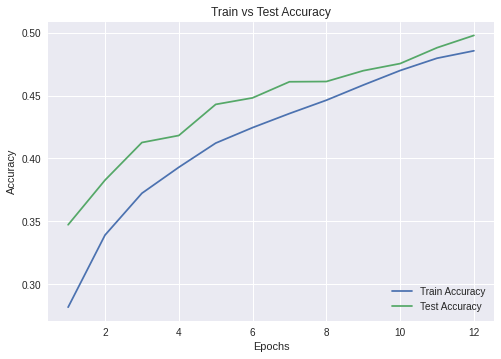

In [ ]:
train_accs = [acc.cpu().item() for acc in train_accs]
test_accs = [acc.cpu().item() for acc in test_accs]
print(train_accs)
print(test_accs)
plt.style.use('seaborn')
plt.plot(range(1, epoch+1), train_accs, label='Train Accuracy')
plt.plot(range(1, epoch+1), test_accs, label='Test Accuracy')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.title("Train vs Test Accuracy")
plt.legend(loc='lower right')